## Data Collection and Summarization

In [ ]:
# Preprocessing for kaggle API
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c godaddy-microbusiness-density-forecasting
! unzip godaddy-microbusiness-density-forecasting.zip

Saving kaggle.json to kaggle (2).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
godaddy-microbusiness-density-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  godaddy-microbusiness-density-forecasting.zip
replace census_starter.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: census_starter.csv      
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [ ]:
# Importing the libraries
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from sklearn import metrics

In [ ]:
# Declaraing and initializing the paths of our datasets
class paths:
    # train and test files have microbusiness density data
    TRAIN = "train.csv"
    TEST = "test.csv"
    # census_starter is an additional file with features to support 
    # microbusiness density in train and test
    CENSUS = "census_starter.csv"

train = pd.read_csv(paths.TRAIN)
census = pd.read_csv(paths.CENSUS)

In [ ]:
# Checking for data types and null values in both the datasets
train.info(), census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pct_bb_2017            3142 non-null   float64
 1   pct_bb_2018            3142 non-null   float64
 2   pct_bb_2019            3142 non

(None, None)

We can see that both have cfips as the common column and we need to convert the datatypes of median_hh_inc_2017 and median_hh_inc_2019 to float64 from census data.

## Data Cleaning

In [ ]:
# Dataframe for census data
df_c = census
df_c["median_hh_inc_2017"] = df_c["median_hh_inc_2017"].astype('float64')
df_c["median_hh_inc_2019"] = df_c["median_hh_inc_2019"].astype('float64')
df_c = df_c.set_index("cfips")
train.head(), train.shape, df_c.head(), df_c.shape

(            row_id  cfips          county    state first_day_of_month  \
 0  1001_2019-08-01   1001  Autauga County  Alabama         2019-08-01   
 1  1001_2019-09-01   1001  Autauga County  Alabama         2019-09-01   
 2  1001_2019-10-01   1001  Autauga County  Alabama         2019-10-01   
 3  1001_2019-11-01   1001  Autauga County  Alabama         2019-11-01   
 4  1001_2019-12-01   1001  Autauga County  Alabama         2019-12-01   
 
    microbusiness_density  active  
 0               3.007682    1249  
 1               2.884870    1198  
 2               3.055843    1269  
 3               2.993233    1243  
 4               2.993233    1243  ,
 (122265, 7),
        pct_bb_2017  pct_bb_2018  pct_bb_2019  pct_bb_2020  pct_bb_2021  \
 cfips                                                                    
 1001          76.6         78.9         80.6         82.7         85.5   
 1003          74.5         78.1         81.8         85.1         87.9   
 1005          57.2    

After looking at the data, we definitely need to scale the columns. One can also think of a use-case to cluster the microdensities based on the different features mapped against the cfips column. Let us combine them into one dataframe and see how the microdensities or cfips depend on these other features.

In [ ]:
train["cfips"].nunique(), train["county"].nunique(), census["cfips"].nunique()

(3135, 1871, 3142)

The shape of train indicates duplicate cfips mapped against the microdensities. So, we need to preprocess the train dataframe to contain unique cfips.

In [ ]:
df_t = train[["cfips", "microbusiness_density"]].groupby("cfips").agg(list)
df_t = pd.DataFrame(df_t["microbusiness_density"].tolist(), index=df_t.index)
df_t.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
cfips,,,,,,,,,,,,,,,,,,,,,
1001,3.007682,2.884870,3.055843,2.993233,2.993233,2.969090,2.909326,2.933231,3.000167,3.004948,...,3.296781,3.334431,3.336785,3.372082,3.313253,3.346197,3.437971,3.423852,3.442677,3.463856
1003,7.239156,7.290936,7.425439,7.426071,7.470274,7.413655,7.282522,7.309610,7.568799,7.603275,...,7.733397,7.823300,7.945311,7.979170,7.907365,8.507496,8.573463,8.491150,8.341701,8.359798
1005,1.073138,0.995794,1.160149,1.000628,1.000628,1.027229,1.022314,1.032144,1.086209,1.081294,...,1.186629,1.206827,1.196728,1.191678,1.186629,1.191678,1.216926,1.196728,1.206827,1.232074
1007,1.310777,1.305176,1.254761,1.254761,1.265965,1.253638,1.248041,1.264831,1.270428,1.287217,...,1.214165,1.236650,1.264755,1.253513,1.247892,1.275998,1.326588,1.292861,1.315346,1.287240
1009,1.544148,1.575892,1.546415,1.573625,1.555485,1.573217,1.536999,1.541526,1.577744,1.575481,...,1.752923,1.777708,1.797986,1.764189,1.748417,1.773202,1.831783,1.836289,1.852060,1.831783


## Feature Engineering

In [ ]:
# Merging the datasets now.
df = pd.merge(df_t, df_c, on="cfips", how="inner")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
cfips,,,,,,,,,,,,,,,,,,,,,
1001,3.007682,2.884870,3.055843,2.993233,2.993233,2.969090,2.909326,2.933231,3.000167,3.004948,...,1.3,1.1,0.7,0.6,1.1,55317.0,58786.0,58731.0,57982.0,62660.0
1003,7.239156,7.290936,7.425439,7.426071,7.470274,7.413655,7.282522,7.309610,7.568799,7.603275,...,1.4,1.3,1.4,1.0,1.3,52562.0,55962.0,58320.0,61756.0,64346.0
1005,1.073138,0.995794,1.160149,1.000628,1.000628,1.027229,1.022314,1.032144,1.086209,1.081294,...,0.5,0.3,0.8,1.1,0.8,33368.0,34186.0,32525.0,34990.0,36422.0
1007,1.310777,1.305176,1.254761,1.254761,1.265965,1.253638,1.248041,1.264831,1.270428,1.287217,...,1.2,1.4,1.6,1.7,2.1,43404.0,45340.0,47542.0,51721.0,54277.0
1009,1.544148,1.575892,1.546415,1.573625,1.555485,1.573217,1.536999,1.541526,1.577744,1.575481,...,1.3,1.4,0.9,1.1,0.9,47412.0,48695.0,49358.0,48922.0,52830.0


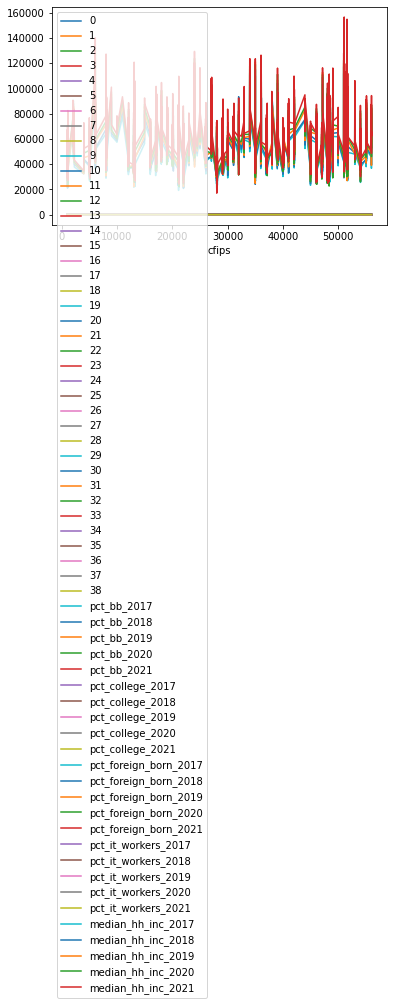

In [ ]:
df.plot()

The plot doesn't have a normal distribution, so we will have to engineer our dataset df. First, we will change int column names to str column names, then we will use median for the imputation of the NA values in the rows and finally scale post the imputation.

In [ ]:
# Renaming int to str column names
df.rename(columns={col: str(col) for col in df.columns if type(col) == int}, inplace=True)

# Imputing of NA values from the dataset
df = df.fillna(df.median())

# Normalizing the values of the dataset to be in the same range for exploratory analysis
df[df.columns] = StandardScaler().fit_transform(df)

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
cfips,,,,,,,,,,,,,,,,,,,,,
1001,-0.123143,-0.221800,-0.116825,-0.197471,-0.196008,-0.197717,-0.204430,-0.197234,-0.190928,-0.191932,...,-0.127691,-0.299261,-0.680187,-0.717426,-0.180029,0.422718,0.524985,0.369067,0.200785,0.283561
1003,0.579172,0.981763,0.589795,1.002836,1.015974,1.022872,1.026619,1.009134,1.055400,1.048777,...,-0.026295,-0.086906,0.065701,-0.313542,0.026481,0.212923,0.318627,0.340081,0.458587,0.392132
1005,-0.444227,-0.737820,-0.423383,-0.737021,-0.735427,-0.731000,-0.735621,-0.721277,-0.713059,-0.710968,...,-0.938860,-1.148682,-0.573631,-0.212571,-0.489795,-1.248714,-1.272605,-1.479131,-1.369804,-1.406054
1007,-0.404785,-0.653309,-0.408083,-0.668208,-0.663598,-0.668823,-0.672079,-0.657135,-0.662804,-0.655406,...,-0.229087,0.019271,0.278811,0.393256,0.852521,-0.484465,-0.457551,-0.420046,-0.226906,-0.256268
1009,-0.366052,-0.579360,-0.360919,-0.581867,-0.585222,-0.581058,-0.590738,-0.580863,-0.578967,-0.577627,...,-0.127691,0.019271,-0.467076,-0.212571,-0.386539,-0.179253,-0.212392,-0.291971,-0.418106,-0.349449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,-0.184104,-0.229038,-0.139822,-0.193253,-0.170181,-0.147781,-0.131193,-0.113336,-0.110961,-0.109118,...,-0.837464,-0.830149,-0.360521,-0.414513,-0.283284,1.623311,1.564226,1.505379,1.252899,1.185616
56039,3.764913,6.259472,3.712603,6.281374,6.276871,6.315148,6.503382,6.345483,6.388847,6.394263,...,-0.736068,-0.193084,0.065701,0.191314,0.749266,2.306079,2.355092,2.199000,2.186631,2.333791
56041,0.143135,0.175222,0.103845,0.176007,0.160707,0.186422,0.169357,0.147034,0.135269,0.196222,...,-0.229087,-0.193084,0.065701,0.393256,-0.386539,0.373601,0.484722,0.698564,1.189643,1.085029


Our data looks good now but it is high dimensional. One solution would be to use PCA for dimensionality reduction but that would result in data loss for clustering. Hence, clustering algorithm with directly work on the scaled dataframe.

## Exploratory Data Analysis

In [ ]:
pca = PCA()
pca.fit(df)
cumsum = np.cumsum(pca.explained_variance_ratio_)
np.argmax(cumsum>=0.95) + 1

8

In [ ]:
pca = PCA()
pca.fit(df)
cumsum = np.cumsum(pca.explained_variance_ratio_)
np.argmax(cumsum>=0.789) + 1

3

To preserve 95% of the data, we need 8 dimensions but that would be too much to visualize. However, with 3 dimensions, we can preserve 78.9% of the data which looks like a good deal for analysis.

In [ ]:
pca_3 = PCA(n_components=3)
pca_3_result = pca_3.fit_transform(df)
d_pca = pd.DataFrame(abs(pca_3.components_), columns=df.columns)
d_pca

,0,1,2,3,4,5,6,7,8,9,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,0.091355,0.147756,0.091265,0.149935,0.150328,0.150571,0.151908,0.150813,0.151169,0.151579,...,0.062756,0.064571,0.062280,0.061168,0.059540,0.096868,0.098540,0.100426,0.101657,0.102004
1,0.024901,0.026508,0.023585,0.020385,0.018249,0.016950,0.015617,0.015013,0.014123,0.010418,...,0.102861,0.105621,0.106377,0.092818,0.092513,0.203346,0.203238,0.203905,0.201114,0.199243
2,0.000233,0.012669,0.000526,0.011969,0.012028,0.012317,0.011132,0.010953,0.011365,0.011040,...,0.004650,0.005651,0.003379,0.000829,0.003280,0.071896,0.067903,0.066443,0.062876,0.061436


In [ ]:
fig = px.scatter_3d(pca_3_result, x=0, y=1, z=2, title="PCA")
fig.show()

These 3 principal components are representing almost 79% of our data. Let us see which features are contributing the most based on a threshold of 0.15.

In [ ]:
temp_pca = d_pca
print("As per PC 1:\n", (temp_pca[temp_pca > 0.15].iloc[0]).dropna())   
print("\n\nAs per PC 2:\n", (temp_pca[temp_pca > 0.15].iloc[1]).dropna())

As per PC 1:
 4     0.150328
5     0.150571
6     0.151908
7     0.150813
8     0.151169
9     0.151579
10    0.152208
11    0.152574
12    0.152638
13    0.152666
14    0.152608
15    0.152551
16    0.152210
17    0.152301
Name: 0, dtype: float64


As per PC 2:
 29                    0.151012
30                    0.153428
31                    0.153373
32                    0.153695
33                    0.155210
pct_bb_2017           0.190189
pct_bb_2018           0.191283
pct_bb_2019           0.190747
pct_bb_2020           0.188062
pct_bb_2021           0.183336
pct_college_2017      0.164301
pct_college_2018      0.165408
pct_college_2019      0.165085
pct_college_2020      0.164440
pct_college_2021      0.163201
median_hh_inc_2017    0.203346
median_hh_inc_2018    0.203238
median_hh_inc_2019    0.203905
median_hh_inc_2020    0.201114
median_hh_inc_2021    0.199243
Name: 1, dtype: float64


There is another technique called T-SNE, t-distributed stochastic neighbor embedding, used for visualizing high dimensional data. This algorithm visualizes while trying to keep similar instances close and dissimilar
instances apart.


In [ ]:
tsne = TSNE(n_components=3, random_state=2, n_jobs=-1) 
results = tsne.fit_transform(df)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
fig = px.scatter_3d(x=results[:,0], y=results[:,1], z=results[:,2], title="TSNE", labels={"x": "PC1", "y": "PC2", "z": "PC3"})
fig.show()

In [ ]:
fig = px.scatter(x=results[:,0], y=results[:,1],
title="TSNE", labels={"x": "PC1", "y": "PC2"})
fig.show()

## Clustering

To understand groups and patterns in the dataset, we have performed different types of clustering. To decide on the number of clusters, elbow test was performed. It resulted in 3 clusters. But, K-means wasn't a great representation of the data as it doesn't work well with globular structures.

### Elbow method

In [ ]:
X=df
inertia = []
for i in range(1,11):
    kmeans = KMeans(
        n_clusters=i, init="k-means++",
        n_init=10,
        tol=1e-04, random_state=42
    )
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
print(inertia)
fig = px.line(x=np.arange(1, 11), y=inertia)
fig.update_layout(title='Inertia vs Cluster Number', xaxis_title='Cluster Number', yaxis_title='Inertia')

# Add an annotation for the elbow
fig.add_shape(type='line', x0=3, x1=3, y0=0, y1=inertia[2], yref='y', line=dict(color='red'))
fig.add_annotation(x=3, y=inertia[2], text='Elbow!', xref='x', yref='y', showarrow=True, arrowhead=7, ax=20, ay=-40)

fig.show()

[200639.99999999988, 133951.5003014737, 105960.76065979617, 86712.19031582541, 77197.30346069558, 69794.64276185475, 64101.00495384679, 59194.04876763915, 56145.73354589507, 52181.94511784116]


### Sillhouette score method

So, another method was to use a metric like Calinski-Harabasz method, Sillhouette score or BIC score. This is another method to determine the right number of clusters. Silhouette coefficient for a sample is (b - a) / max(a, b), where a is the mean intra-cluster distance and b is the mean nearest-cluster distance which a sample is not a part of.
The Elbow method is based on the reduction in within-cluster variance, while the Silhouette Score is based on the similarity of samples to their own cluster versus other clusters.

Parameter: {'n_clusters': 2} Score 0.5384972591785429
Parameter: {'n_clusters': 3} Score 0.47939509658215024
Parameter: {'n_clusters': 4} Score 0.3262249333460799
Parameter: {'n_clusters': 5} Score 0.22406032888527105
Parameter: {'n_clusters': 10} Score 0.18665328997404834
Parameter: {'n_clusters': 15} Score 0.16907198480686833


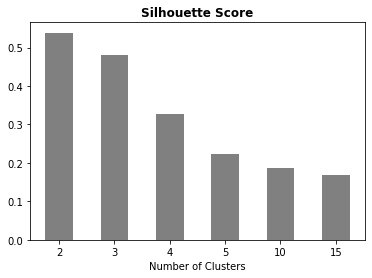

In [ ]:
X=df
# probable clusters
parameters = [2, 3, 4, 5, 10, 15]
# ParameterGrid to keep a track of our clusters
parameter_grid = ParameterGrid({'n_clusters': parameters})
best_score = -1
kmeans_model = KMeans()
silhouette_scores = np.zeros(len(parameters))

# evaluation based on silhouette_score
for i, p in enumerate(parameter_grid):
    # setting the current parameter form the list
    kmeans_model.set_params(**p) 
    kmeans_model.fit(X)
    # calculating silhoutte score
    ss = metrics.silhouette_score(X, kmeans_model.labels_)
    silhouette_scores[i] = ss
    # checking for the best score
    if ss > best_score:
        best_score = ss
        best_grid = p
    print('Parameter:', p, 'Score', ss)
    
# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='grey', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()


### K-means clustering

In [ ]:
X = df
kmeans = KMeans(
        n_clusters=2, init="k-means++",
        n_init=10,
        tol=1e-04, random_state=42
    ).fit(X)
labels = kmeans.labels_
fig = px.scatter_3d(x=results[:,0], y=results[:,1], z=results[:,2], color=labels,
title="K-Means Clustering", labels={"x": "PC1", "y": "PC2", "z": "PC3"})
fig.show()

### Spectral clustering

Next is Spectral clustering which is performed on globular structures. But, they need complete graph matrix to perform clustering on. So, we are using the t-sne results and performed clustering on the points.

In [ ]:
X = results
clustering = SpectralClustering(n_clusters=2).fit(X)
labels = clustering.labels_
fig = px.scatter_3d(x=results[:,0], y=results[:,1], z=results[:,2], color=labels,
title="Spectral Clustering", labels={"x": "PC1", "y": "PC2", "z": "PC3"})
fig.show()

### DBSCAN clustering

Another experiment was performed to check how density based clustering would behave instead of distance based. It doesn’t work well in high-dimensional data which is why we have used the original scaled dataframe. We performed DBSCAN which is robust to outliers and can find arbitarily shaped clusters but is sensitive to parameters MinPts and Eps.

In [ ]:
X = results
clustering = DBSCAN(eps=0.2, min_samples=2).fit(X)
labels = clustering.labels_
fig = px.scatter_3d(x=results[:,0], y=results[:,1], z=results[:,2], color=labels,
title="DBSCAN Clustering", labels={"x": "PC1", "y": "PC2", "z": "PC3"})
fig.show()